# LSTM neural network for EMS demand predictions
This notebook contains the code for applying neural network models to smart city data <br>


In [ ]:
# GPU check:

import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
print("Show System RAM Memory: \n \n")
!cat /proc/meminfo | egrep "MemTotal"
device_lib.list_local_devices()

Show System RAM Memory: 
 

MemTotal:       26751688 kB


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4382755674638507369, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6164484291761766007
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16293645537223117730
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15473775744
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1411524085381826352
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [ ]:
# get additional info about the hardware in the cloud
%cat /proc/cpuinfo
%cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

Tutorial about google colab and GPU access: <br>
https://www.youtube.com/watch?v=f1UK8KPt-KU

In [ ]:
# this allows for accessing files stored in your google drive using the path "/gdrive/My Drive/"
# mounting google drive locally:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


$\textbf{Background:}$ Tensors are data structures that you can think of as multi-dimensional arrays. Tensors are represented as n-dimensional arrays of base dataypes such as a string or integer -- they provide a way to generalize vectors and matrices to higher dimensions. The shape of a Tensor defines its number of dimensions and the size of each dimension. The rank of a Tensor provides the number of dimensions. Scalars can be used to create 0-d Tensors. Vectors and lists can be used to create 1-d Tensors. Matrices can be used to create 2-d or higher rank Tensors. The shape of a Tensor provides the number of elements in each Tensor dimension.

$\textbf{Neural Networks in Tensorflow:}$ We can also define neural networks in TensorFlow. TensorFlow uses a high-level API called Keras that provides a powerful, intuitive framework for building and training deep learning models. <br> 
Tensors can flow through abstract types called $\textit{Layers}$ -- the building blocks of neural networks. Layers implement common neural networks operations, and are used to update weights, compute losses, and define inter-layer connectivity <br>
<br>
Conveniently, TensorFlow has defined a number of Layers that are commonly used in neural networks, for example a Dense. Now, instead of using a single Layer to define our simple neural network, we'll use the Sequential model from Keras and a single Dense layer to define our network. With the Sequential API, you can readily create neural networks by stacking together layers like building blocks.

# Implementation

In [ ]:
## -- Packages  -- ##

# General
import pandas as pd
import numpy as np

# Time formatting
import datetime

# Load and save data
import pickle
# progress bar
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
#import tikzplotlib as tkz

In [ ]:
##  NN libaries ##
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt


## ML libraries ##
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

### Load data

In [ ]:
#load taxi data. Generated in notebook 'taxi_trips'
filename = '/gdrive/My Drive/Colab Notebooks/emergency_dispatches_bronx_H'
infile = open(filename,'rb')
emergency_ts = pickle.load(infile)
infile.close()

In [ ]:
emergency_ts.shape

(8760,)

### Preprocessing

In [ ]:
## Remove last 15 days of data since they are either erroneous or part of the test set to the robustness checks
emergency_ts_final = emergency_ts.iloc[0:-360]
emergency_ts_final.shape

(8400,)

In [ ]:
## Set paramaters
input_lags = 60 # 2 and a half times the seasonal period
output_lags = 24 # we predict 24 hours ahead
n_test = 24 # output_lags 

In [ ]:
## Split data in train and test set
train = emergency_ts_final[0:-n_test]
test = emergency_ts_final[-n_test:]
print(train.shape)
print(test.shape)

(8376,)
(24,)


In [ ]:
## Create lagged values for both input and output window (24)
data = train.copy()
n_train = len(data)

##Create lagged values for input
df = pd.DataFrame()
for i in range(input_lags,0,-1):
    df['t-' + str(i)] = data.shift(i)

##Create lagged values for output
for j in range(0,output_lags,1):
    df['t+' + str(j)] = data.shift(-j)
    
df = df[input_lags:(n_train-output_lags+1)]

In [ ]:
df.head()

,t-60,t-59,t-58,t-57,t-56,t-55,t-54,t-53,t-52,t-51,t-50,t-49,t-48,t-47,t-46,t-45,t-44,t-43,t-42,t-41,t-40,t-39,t-38,t-37,t-36,t-35,t-34,t-33,t-32,t-31,t-30,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,...,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t+0,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15,t+16,t+17,t+18,t+19,t+20,t+21,t+22,t+23
FIRST_ASSIGNMENT_DATETIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03 12:00:00,41.0,48.0,36.0,55.0,48.0,27.0,47.0,46.0,58.0,51.0,42.0,50.0,62.0,44.0,47.0,58.0,44.0,53.0,44.0,43.0,44.0,38.0,45.0,35.0,34.0,38.0,26.0,23.0,17.0,21.0,27.0,39.0,37.0,53.0,67.0,50.0,69.0,59.0,66.0,50.0,...,60.0,45.0,41.0,34.0,36.0,24.0,19.0,29.0,21.0,23.0,31.0,26.0,42.0,57.0,63.0,56.0,65,56.0,47.0,59.0,58.0,55.0,48.0,47.0,44.0,36.0,37.0,40.0,39.0,31.0,22.0,17.0,13.0,17.0,31.0,37.0,46.0,48.0,38.0,54.0
2019-01-03 13:00:00,48.0,36.0,55.0,48.0,27.0,47.0,46.0,58.0,51.0,42.0,50.0,62.0,44.0,47.0,58.0,44.0,53.0,44.0,43.0,44.0,38.0,45.0,35.0,34.0,38.0,26.0,23.0,17.0,21.0,27.0,39.0,37.0,53.0,67.0,50.0,69.0,59.0,66.0,50.0,70.0,...,45.0,41.0,34.0,36.0,24.0,19.0,29.0,21.0,23.0,31.0,26.0,42.0,57.0,63.0,56.0,65.0,56,47.0,59.0,58.0,55.0,48.0,47.0,44.0,36.0,37.0,40.0,39.0,31.0,22.0,17.0,13.0,17.0,31.0,37.0,46.0,48.0,38.0,54.0,68.0
2019-01-03 14:00:00,36.0,55.0,48.0,27.0,47.0,46.0,58.0,51.0,42.0,50.0,62.0,44.0,47.0,58.0,44.0,53.0,44.0,43.0,44.0,38.0,45.0,35.0,34.0,38.0,26.0,23.0,17.0,21.0,27.0,39.0,37.0,53.0,67.0,50.0,69.0,59.0,66.0,50.0,70.0,51.0,...,41.0,34.0,36.0,24.0,19.0,29.0,21.0,23.0,31.0,26.0,42.0,57.0,63.0,56.0,65.0,56.0,47,59.0,58.0,55.0,48.0,47.0,44.0,36.0,37.0,40.0,39.0,31.0,22.0,17.0,13.0,17.0,31.0,37.0,46.0,48.0,38.0,54.0,68.0,51.0
2019-01-03 15:00:00,55.0,48.0,27.0,47.0,46.0,58.0,51.0,42.0,50.0,62.0,44.0,47.0,58.0,44.0,53.0,44.0,43.0,44.0,38.0,45.0,35.0,34.0,38.0,26.0,23.0,17.0,21.0,27.0,39.0,37.0,53.0,67.0,50.0,69.0,59.0,66.0,50.0,70.0,51.0,55.0,...,34.0,36.0,24.0,19.0,29.0,21.0,23.0,31.0,26.0,42.0,57.0,63.0,56.0,65.0,56.0,47.0,59,58.0,55.0,48.0,47.0,44.0,36.0,37.0,40.0,39.0,31.0,22.0,17.0,13.0,17.0,31.0,37.0,46.0,48.0,38.0,54.0,68.0,51.0,55.0
2019-01-03 16:00:00,48.0,27.0,47.0,46.0,58.0,51.0,42.0,50.0,62.0,44.0,47.0,58.0,44.0,53.0,44.0,43.0,44.0,38.0,45.0,35.0,34.0,38.0,26.0,23.0,17.0,21.0,27.0,39.0,37.0,53.0,67.0,50.0,69.0,59.0,66.0,50.0,70.0,51.0,55.0,53.0,...,36.0,24.0,19.0,29.0,21.0,23.0,31.0,26.0,42.0,57.0,63.0,56.0,65.0,56.0,47.0,59.0,58,55.0,48.0,47.0,44.0,36.0,37.0,40.0,39.0,31.0,22.0,17.0,13.0,17.0,31.0,37.0,46.0,48.0,38.0,54.0,68.0,51.0,55.0,56.0


In [ ]:
## splitting the training set into labels and features
X_train = df.iloc[:,:input_lags] # from the beginning to input_lags
Y_train = df.iloc[:,input_lags:] # from input_lags to the end

## Use the last window of the training set as the features for the test set. This requires a combination of 
## X_train and Y_train.
X_test = X_train.iloc[len(X_train) - 1,:][output_lags:]
X_test = X_test.append(Y_train.iloc[len(Y_train) - 1,:]).values.reshape(1,input_lags)
Y_test = test[:output_lags].values.reshape(1,output_lags)

X_train = X_train.values # 54 steps back (54 lags)
Y_train = Y_train.values # 24 steps ahead

print("X_train: " + "type: " + str(type(X_train)) + "\tshape: " + str(X_train.shape))
print("Y_train: " + "type: " + str(type(Y_train)) + "\tshape: " + str(Y_train.shape))
print("X_test: " + "type: " + str(type(X_test)) + "\tshape: " + str(X_test.shape))
print("Y_test: " + "type: " + str(type(Y_test)) + "\tshape: " + str(Y_test.shape))

X_train: type: <class 'numpy.ndarray'>	shape: (8293, 60)
Y_train: type: <class 'numpy.ndarray'>	shape: (8293, 24)
X_test: type: <class 'numpy.ndarray'>	shape: (1, 60)
Y_test: type: <class 'numpy.ndarray'>	shape: (1, 24)


$\textbf{When Should You Use Normalization And Standardization:}$

Normalization is a good technique to use when you do not know the distribution of your data or when you know the distribution is not Gaussian (a bell curve). Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data, such as k-nearest neighbors and artificial neural networks.

In [ ]:
## normalizing the data

# MinMaxScaler() transforms features by scaling each feature to a given range (given by feature_range())
# The cost of having this bounded range is that we will end up with smaller standard deviations, which can 
# suppress the effect of outliers. Thus MinMax Scalar is sensitive to outliers

#scaler = MinMaxScaler(feature_range=(0, 1))
#df_x = df.iloc[:,0:24]
# the method fit_transform() computes the min and the max used for scaling and then carries out the transformation
#df_x_scaled = scaler.fit_transform(df_x)
# later, inverse_transform() can be used to undo the scaling to the feature_range

# normalizing the entire dataset
#df_normalized = scaler.fit_transform(df)

# Building the LSTM neural network model

# Method 1 (Keras)

Tensorflow 2.0 Impelementation <br>
(tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality)


TF 2 keras RNN tutorial
https://www.tensorflow.org/guide/keras/rnn <br>
TF 2 time series forecasting tutorial
https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
# configuring the inputs for the model
# For Keras, the input has to be in the shape (samples, time steps, features)
# 24 timestep with n features where n is equal to the shape of column [1] of X_train or X_test

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
X_train.shape

(8293, 1, 60)

In [ ]:
X_test.shape

(1, 1, 60)

In [ ]:
# creating a leaky_relu activation function

def my_leaky_relu(x):
    return tf.nn.leaky_relu(x)

## Gridsearch CV for the optimal hyperparameters

Guide to Hyperparameter tuning: <br>
https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594
Dropout regularization for RNNs: <br>
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

## One step Gridsearch CV for all hyperparameters

**Blogpost Hyperparametertuning LSTM/GRU:**

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

**Overview of Gradient Descent Algorithms:**

https://ruder.io/optimizing-gradient-descent/index.html#adagrad

In [ ]:
# creating the parameter grid as a dictionary

##
batch_size = [100, 200, 400]
epochs = [500, 1000, 1500]
neurons = [1000, 1500, 2000]
dropout = [0.0]
learning_rate = [0.01, 0.001, 0.0005]
optimizer = ['Adam']


param_grid_cv = dict(batch_size=batch_size, epochs=epochs, neurons=neurons, dropout = dropout, optimizer=optimizer, learning_rate = learning_rate)

In [ ]:
# refined grid

batch_size = [150,250]
epochs = [750, 1000]
neurons = [1500, 2000]
dropout = [0.0]
learning_rate = [0.01, 0.001, 0.0001]
optimizer = ['Adam', 'Adadelta']

param_grid_cv = dict(batch_size=batch_size, epochs=epochs, neurons=neurons, dropout = dropout, optimizer=optimizer, learning_rate = learning_rate)

In [ ]:
# setting up the model
# the default activation function is tanh()

def model(neurons = 128, epochs = 100, batch_size =100, dropout = 0.0, learning_rate = 0.001, optimizer="Adam"):
    model = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences = False, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

# output layer with 24 neurons
    model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
    
    return model

In [ ]:
# using the KerasRegressor as a wrapper to carry out the GridSearchCV
model_cv = KerasRegressor(build_fn = model, verbose=1)

In [ ]:
# k fold CV (NEW GRID for EMS data)
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train,Y_train)

# n_jobs set to 4 means that 4 cores are used for parallel processing; set n_jobs=-1 to use all available cores

grid_cv = GridSearchCV(estimator = model_cv, param_grid = param_grid_cv, cv = inner_loop, verbose = 3, n_jobs=-1)
grid_result = grid_cv.fit(X_train,Y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 207.4min


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 377.6min finished


Epoch 1/500
21/21 [==============================] - 0s 5ms/step - loss: 1116.5753 - mean_squared_error: 1116.5753
Epoch 2/500
21/21 [==============================] - 0s 4ms/step - loss: 101.0667 - mean_squared_error: 101.0667
Epoch 3/500
21/21 [==============================] - 0s 4ms/step - loss: 77.0788 - mean_squared_error: 77.0788
Epoch 4/500
21/21 [==============================] - 0s 4ms/step - loss: 71.8170 - mean_squared_error: 71.8170
Epoch 5/500
21/21 [==============================] - 0s 5ms/step - loss: 67.8967 - mean_squared_error: 67.8967
Epoch 6/500
21/21 [==============================] - 0s 4ms/step - loss: 65.5544 - mean_squared_error: 65.5544
Epoch 7/500
21/21 [==============================] - 0s 4ms/step - loss: 64.0962 - mean_squared_error: 64.0962
Epoch 8/500
21/21 [==============================] - 0s 4ms/step - loss: 63.0455 - mean_squared_error: 63.0455
Epoch 9/500
21/21 [==============================] - 0s 4ms/step - loss: 62.2325 - mean_squared_error: 62.

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# most recent gridsearch result:




In [ ]:
# summarize results ( 10 sep)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -56.360697 using {'batch_size': 400, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.01, 'neurons': 1000, 'optimizer': 'Adam'}
-61.486342 (2.695756) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.01, 'neurons': 1000, 'optimizer': 'Adam'}
-63.857010 (7.649891) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.01, 'neurons': 1500, 'optimizer': 'Adam'}
-65.710827 (8.015645) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.01, 'neurons': 2000, 'optimizer': 'Adam'}
-61.973459 (8.681587) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adam'}
-64.682561 (10.014578) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.001, 'neurons': 1500, 'optimizer': 'Adam'}
-64.815759 (11.201939) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.001, 'neurons': 2000, 'optimizer': 'Adam'}
-65.609568 (7.718510

## Fitting the optimal model with all gridsearched parameters

In [ ]:
LSTM_model = tf.keras.Sequential()

LSTM_model.add(tf.keras.layers.LSTM(units=1000, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer 
LSTM_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
LSTM_model.fit(X_train, Y_train, epochs= 500, batch_size=400, verbose=1)

Epoch 1/500
21/21 [==============================] - 0s 4ms/step - loss: 664.7762 - mean_squared_error: 664.7762
Epoch 2/500
21/21 [==============================] - 0s 4ms/step - loss: 92.7919 - mean_squared_error: 92.7919
Epoch 3/500
21/21 [==============================] - 0s 4ms/step - loss: 74.0003 - mean_squared_error: 74.0003
Epoch 4/500
21/21 [==============================] - 0s 5ms/step - loss: 68.3566 - mean_squared_error: 68.3566
Epoch 5/500
21/21 [==============================] - 0s 4ms/step - loss: 65.7489 - mean_squared_error: 65.7489
Epoch 6/500
21/21 [==============================] - 0s 4ms/step - loss: 64.4030 - mean_squared_error: 64.4030
Epoch 7/500
21/21 [==============================] - 0s 4ms/step - loss: 63.3402 - mean_squared_error: 63.3402
Epoch 8/500
21/21 [==============================] - 0s 4ms/step - loss: 62.7954 - mean_squared_error: 62.7954
Epoch 9/500
21/21 [==============================] - 0s 4ms/step - loss: 62.1833 - mean_squared_error: 62.1833

Deep LSTM network (input layer - 2 stacked LSTM hidden layers - output layer)


In [ ]:
## 2 HL Deep LSTM model (based on combination from the lowest training MSE loss)

# To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal LSTM model with the gridsearched hyperparameters
Deep_LSTM_model = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_LSTM_model.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd LSTM hidden layer
Deep_LSTM_model.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 24 neurons
Deep_LSTM_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_LSTM_model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.0001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_LSTM_model.fit(X_train, Y_train, epochs=1000, batch_size=150, verbose=1)



In [ ]:
## 2 HL Deep LSTM model (based on combination from the "best"(highest) training MSE loss)

# To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal LSTM model with the gridsearched hyperparameters
Deep_LSTM_model_2 = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_LSTM_model_2.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd LSTM hidden layer
Deep_LSTM_model_2.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 24 neurons
Deep_LSTM_model_2.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_LSTM_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_LSTM_model_2.fit(X_train, Y_train, epochs=750, batch_size=250, verbose=1)

Deep LSTM network (input layer - 3 stacked LSTM layers - output layer)

In [ ]:
# To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal LSTM model with the gridsearched hyperparameters
Deep_LSTM_model2 = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_LSTM_model2.add(tf.keras.layers.LSTM(units=1000, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd LSTM hidden layer
Deep_LSTM_model2.add(tf.keras.layers.LSTM(units=1000, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 3rd LSTM hidden layer
Deep_LSTM_model2.add(tf.keras.layers.LSTM(units=1000, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 10 ne
Deep_LSTM_model2.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_LSTM_model2.fit(X_train, Y_train, epochs=250, batch_size=500, verbose=1)

Deep LSTM network (input layer - 5 stacked LSTM layers - output layer)

In [ ]:
# To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal LSTM model with the gridsearched hyperparameters
Deep_LSTM_model3 = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd LSTM hidden layer
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 3rd LSTM hidden layer
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 4th LSTM hidden layer
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 5th LSTM hidden layer
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer 
Deep_LSTM_model3.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_LSTM_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_LSTM_model3.fit(X_train, Y_train, epochs=500, batch_size=250, verbose=1)

## Undoing the normalization, making predictions and computing the test error

In [ ]:
# making predictions (regular LSTM)
y_train_pred = LSTM_model.predict(X_train)
y_test_pred = LSTM_model.predict(X_test)

# making predictions (deep LSTM 2 hidden layers)
y_train_pred_deep = Deep_LSTM_model.predict(X_train)
y_test_pred_deep = Deep_LSTM_model.predict(X_test)

# making predictions (deep LSTM 3 hidden layers)
y_train_pred_deep2 = Deep_LSTM_model_2.predict(X_train)
y_test_pred_deep2 = Deep_LSTM_model_2.predict(X_test)

# making predictions (deep LSTM 5 hidden layers)
y_train_pred_deep3 = Deep_LSTM_model3.predict(X_train)
y_test_pred_deep3 = Deep_LSTM_model3.predict(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

In [ ]:
# MSE LSTM forecast
mse_LSTM = mean_squared_error(Y_test, y_test_pred)
mse_LSTM

24.308184280664438

In [ ]:
# RMSE LSTM forecast
rmse_LSTM = sqrt(mse_LSTM)
rmse_LSTM

4.930333080093519

In [ ]:
# mae LSTM
mae_LSTM = mean_absolute_error(Y_test, y_test_pred)
mae_LSTM

3.8120567003885903

In [ ]:
# custom MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = Y_test
y_pred = y_test_pred

In [ ]:
# MAPE LSTM 1 HL
y_true = Y_test
y_pred = y_test_pred

mean_absolute_percentage_error(y_true,y_pred)

9.962394480283717

In [ ]:
y_test_pred2 = LSTM_model_2.predict(X_test)

In [ ]:
y_test_pred2

In [ ]:
# MSE LSTM forecast (1HL) model 2
mse_LSTM2 = mean_squared_error(Y_test, y_test_pred2)
mse_LSTM2

In [ ]:
# RMSE LSTM forecast (1HL) model 2
rmse_LSTM2 = sqrt(mse_LSTM2)
rmse_LSTM2

In [ ]:
# mae LSTM (1hl) model 2
mae_LSTM2 = mean_absolute_error(Y_test, y_test_pred2)
mae_LSTM2

In [ ]:
# MAPE LSTM 1 HL model 2
y_true = Y_test
y_pred = y_test_pred2

mean_absolute_percentage_error(y_true,y_pred)

In [ ]:
# MSE Deep LSTM forecast (2HL)
mse_LSTM1 = mean_squared_error(Y_test, y_test_pred_deep)
mse_LSTM1

In [ ]:
# RMSE Deep LSTM forecast (2HL)
rmse_LSTM1 = sqrt(mse_LSTM1)
rmse_LSTM1

In [ ]:
# mae DeepLSTM (2HL)
mae_LSTM1 = mean_absolute_error(Y_test, y_test_pred_deep)
mae_LSTM1

In [ ]:
# MAPE LSTM 2 HL
y_true = Y_test
y_pred = y_test_pred_deep

mean_absolute_percentage_error(y_true,y_pred)

In [ ]:
# MSE Deep LSTM forecast (2HL) deep model 2
mse_deepLSTM2 = mean_squared_error(Y_test, y_test_pred_deep2)
mse_deepLSTM2

In [ ]:
# RMSE Deep LSTM forecast (2HL) deep model 2
rmse_deepLSTM2 = sqrt(mse_deepLSTM2)
rmse_deepLSTM2

In [ ]:
# mae DeepLSTM (2HL) deep model 2
mae_deepLSTM2 = mean_absolute_error(Y_test, y_test_pred_deep2)
mae_deepLSTM2

In [ ]:
# MAPE LSTM 2 HL deep model 2
y_true = Y_test
y_pred = y_test_pred_deep2

mean_absolute_percentage_error(y_true,y_pred)

In [ ]:
# MSE Deep LSTM forecast (3HL)
mse_LSTM2 = mean_squared_error(Y_test, y_test_pred_deep2)
mse_LSTM2

In [ ]:
# RMSE Deep LSTM forecast (3HL)
rmse_LSTM2 = sqrt(mse_LSTM2)
rmse_LSTM2

In [ ]:
# mae Deep LSTM (3HL)
mae_LSTM2 = mean_absolute_error(Y_test, y_test_pred_deep2)
mae_LSTM2

In [ ]:
# MSE Deep LSTM forecast (5HL)
mse_LSTM3 = mean_squared_error(Y_test, y_test_pred_deep3)
mse_LSTM3

In [ ]:
# RMSE Deep LSTM forecast (5HL)
rmse_LSTM3 = sqrt(mse_LSTM3)
rmse_LSTM3

In [ ]:
# mae Deep LSTM (5HL)
mae_LSTM2 = mean_absolute_error(Y_test, y_test_pred_deep3)
mae_LSTM2

In [ ]:
# MAPE LSTM 3 HL
y_true = Y_test
y_pred = y_test_pred_deep2

mean_absolute_percentage_error(y_true,y_pred)

In [ ]:
# MAPE LSTM 5 HL
y_true = Y_test
y_pred = y_test_pred_deep3

mean_absolute_percentage_error(y_true,y_pred)

## Prediction intervals using quantile regression

In [ ]:
# quantile regression loss = tilted loss = pinball loss
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

2 separate PI networks 1 hidden layer LSTM

In [ ]:
## build lower bound with different loss (95% PI)
q = 0.025


# fitting the LSTM model with the gridsearched hyperparameters
lower_PI_model = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
lower_PI_model.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer with 10 neurons
lower_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
lower_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
lower_PI_model.fit(X_train, Y_train, epochs=500, batch_size=400, verbose=1)


Epoch 1/500
21/21 [==============================] - 0s 5ms/step - loss: 0.5894
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4557
Epoch 3/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4421
Epoch 4/500
21/21 [==============================] - 0s 6ms/step - loss: 0.4360
Epoch 5/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4320
Epoch 6/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4295
Epoch 7/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4264
Epoch 8/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4251
Epoch 9/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4235
Epoch 10/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4215
Epoch 11/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4187
Epoch 12/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4161
Epoch 13/500
21/21 [=================

In [ ]:
## build upper bound with different loss (95% PI)
q = 0.975


# fitting the LSTM model with the gridsearched hyperparameters
upper_PI_model = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
upper_PI_model.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer with 10 neurons
upper_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
upper_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
upper_PI_model.fit(X_train, Y_train, epochs=500, batch_size=400, verbose=1)

Epoch 1/500
21/21 [==============================] - 0s 5ms/step - loss: 6.9177
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 1.3382
Epoch 3/500
21/21 [==============================] - 0s 5ms/step - loss: 0.6937
Epoch 4/500
21/21 [==============================] - 0s 5ms/step - loss: 0.6042
Epoch 5/500
21/21 [==============================] - 0s 5ms/step - loss: 0.5669
Epoch 6/500
21/21 [==============================] - 0s 5ms/step - loss: 0.5489
Epoch 7/500
21/21 [==============================] - 0s 6ms/step - loss: 0.5397
Epoch 8/500
21/21 [==============================] - 0s 5ms/step - loss: 0.5307
Epoch 9/500
21/21 [==============================] - 0s 5ms/step - loss: 0.5263
Epoch 10/500
21/21 [==============================] - 0s 5ms/step - loss: 0.5167
Epoch 11/500
21/21 [==============================] - 0s 5ms/step - loss: 0.5116
Epoch 12/500
21/21 [==============================] - 0s 5ms/step - loss: 0.5095
Epoch 13/500
21/21 [=================

In [ ]:
# predictions from PI models

lower_pred = lower_PI_model.predict(X_test)
upper_pred = upper_PI_model.predict(X_test)

PIs for the DLSTM model (2HL) two networks

In [ ]:
## build lower bound with different loss (95% PI)
q = 0.025


# fitting the LSTM model with the gridsearched hyperparameters
lower_PI_model_deep = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
lower_PI_model_deep.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

lower_PI_model_deep.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 10 neurons
lower_PI_model_deep.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
lower_PI_model_deep.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
lower_PI_model_deep.fit(X_train, Y_train, epochs=750, batch_size=168, verbose=1)

In [ ]:
## build upper bound with different loss (95% PI)
q = 0.975


# fitting the LSTM model with the gridsearched hyperparameters
upper_PI_model_deep = tf.keras.Sequential()

# Add a LSTM layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of LSTM will be a 3D tensor of shape (batch_size, timesteps, 128)
upper_PI_model_deep.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

upper_PI_model_deep.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 10 neurons
upper_PI_model_deep.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
upper_PI_model_deep.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
upper_PI_model_deep.fit(X_train, Y_train, epochs=750, batch_size=168, verbose=1)

In [ ]:
# predictions from PI models

lower_pred_deep = lower_PI_model_deep.predict(X_test)
upper_pred_deep = upper_PI_model_deep.predict(X_test)

# Exporting the PI bounds

In [ ]:
upper_pred_1hl = pd.Series(upper_pred[0])
lower_pred_1hl = pd.Series(lower_pred[0])
upper_pred_2hl = pd.Series(upper_pred_deep[0])
lower_pred_2hl = pd.Series(lower_pred_deep[0])

In [ ]:
# export the PI bounds for plotting in R
LSTM_ems_pi_df = pd.DataFrame()



# adding a column with the test data
LSTM_ems_pi_df["upper_bound_1hl"] = upper_pred_1hl
LSTM_ems_pi_df["lower_bound_1hl"] = lower_pred_1hl
LSTM_ems_pi_df["upper_bound_2hl"] = upper_pred_2hl
LSTM_ems_pi_df["lower_bound_2hl"] = lower_pred_2hl


LSTM_ems_pi_df


,upper_bound_1hl,lower_bound_1hl,upper_bound_2hl,lower_bound_2hl
0,51.226219,22.637360,49.642345,22.688736
1,44.487282,18.688255,43.498501,18.115862
2,45.546131,14.426312,42.276516,14.929735
3,41.711651,15.577353,39.382565,13.962833
4,44.455921,13.124547,35.150127,13.958202
5,42.239979,14.249686,37.565582,14.230879
6,44.803883,19.390198,42.746994,15.171696
7,49.998600,15.899341,49.905899,16.465281
8,56.137661,21.802147,59.032463,17.474821
9,60.421249,24.927326,65.476807,24.757841


In [ ]:
# export the LSTM predictions and the test data to google drive
from google.colab import  drive

drive.mount('/drive')

LSTM_ems_pi_df.to_csv('/drive/My Drive/Colab Notebooks/LSTM_ems_pis.csv', index=False)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


PI measure calculations

In [ ]:
def PCIP(upper, lower, test_set):
    n = len(Y_test[0,:])
    count = 0
    PCIP = 0
    
    for i in range(n):
        if (upper[0,i] > test_set[0,i] and lower[0,i] < test_set[0,i]):
            count = count + 1 
            
    PCIP = count/n
    return PCIP

In [ ]:
PCIP(upper = upper_pred, lower = lower_pred, test_set = Y_test)

0.9583333333333334

In [ ]:
#MPIW
np.mean(upper_pred - lower_pred)

27.76859

# Plotting the predictions

plot 2 PI networks

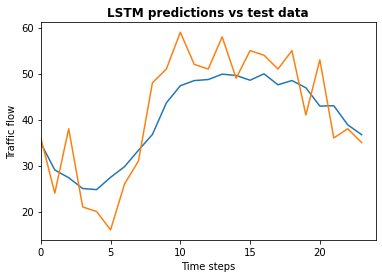

In [ ]:
# LSTM model (1HL) predictions vs test data

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred), label="LSTM_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
#plt.fill_between(x = np.arange(0,24), y1= np.transpose(lower_pred).reshape(24), y2=np.transpose(upper_pred).reshape(24), color = "b", alpha = 0.10)

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("LSTM predictions vs test data", fontweight="bold")
#legend = plt.legend(["LSTM" predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "LSTM_predictions.tex")

plt.show()


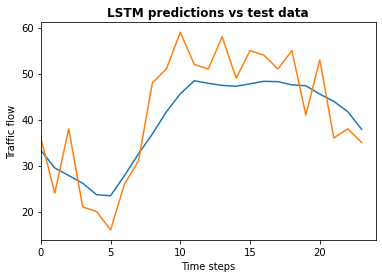

In [ ]:
# LSTM model (2HL) predictions vs test data

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred_deep), label="LSTM_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
#plt.fill_between(x = np.arange(0,24), y1= np.transpose(lower_pred_deep).reshape(24), y2=np.transpose(upper_pred_deep).reshape(24), color = "b", alpha = 0.10)

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("LSTM predictions vs test data", fontweight="bold")
#legend = plt.legend(["LSTM" predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "LSTM_predictions.tex")

plt.show()


# Exporting the point forecasts


In [ ]:
LSTM_ems_preds_trial = pd.Series(y_test_pred[0])
LSTM_ems_preds_deep_trial = pd.Series(y_test_pred_deep[0])


In [ ]:
# export the LSTM predictions and the test data to google drive
from google.colab import  drive

drive.mount('/drive')

#LSTM_ems_preds_trial.to_csv('/drive/My Drive/Colab Notebooks/LSTM_ems_preds_trial.csv', index=False)
#LSTM_ems_preds_deep_trial.to_csv('/drive/My Drive/Colab Notebooks/LSTM_ems_preds_deep_trial.csv', index=False)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
